# Data Loading and Preprocessing

In [2]:
import pandas as pd
import yfinance as yf
import scipy.stats as stats
from pandas.plotting import lag_plot
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from sklearn.metrics import mean_squared_error
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

In [3]:
# series = pd.read_csv(r"C:\Users\Pavan Yadav\Desktop\PSY\SEM 3\TimeSeries\CaseStudy\HDFCBANK.csv",
#                     header=0,
#                     index_col=0,
#                     parse_dates=True)

series = yf.download("HDFCBANK.NS", start="1995-11-08", end="2025-09-10")

series = series['Close']
# series.drop(columns=['Symbol', 'Series', 'Prev Close', 'Open', 'High', 'Low', 'Last', 'VWAP', 'Volume', 'Turnover', 'Trades', 'Deliverable Volume', '%Deliverble'], inplace=True)
series.columns = ['Price']

series = series.squeeze()

C:\Users\pavan\AppData\Local\Temp\ipykernel_12036\922141223.py:6: FutureWarning: YF.download() has changed argument auto_adjust default to True
  series = yf.download("HDFCBANK.NS", start="1995-11-08", end="2025-09-10")
[*********************100%***********************]  1 of 1 completed


In [4]:
series.info()

<class 'pandas.core.series.Series'>
DatetimeIndex: 7457 entries, 1996-01-01 to 2025-09-09
Series name: Price
Non-Null Count  Dtype  
--------------  -----  
7457 non-null   float64
dtypes: float64(1)
memory usage: 116.5 KB


In [5]:
series.describe()

count    7457.000000
mean      231.474766
std       283.503606
min         0.831992
25%         9.534921
50%        87.799469
75%       434.097321
max      1012.900024
Name: Price, dtype: float64

# Data Visualization

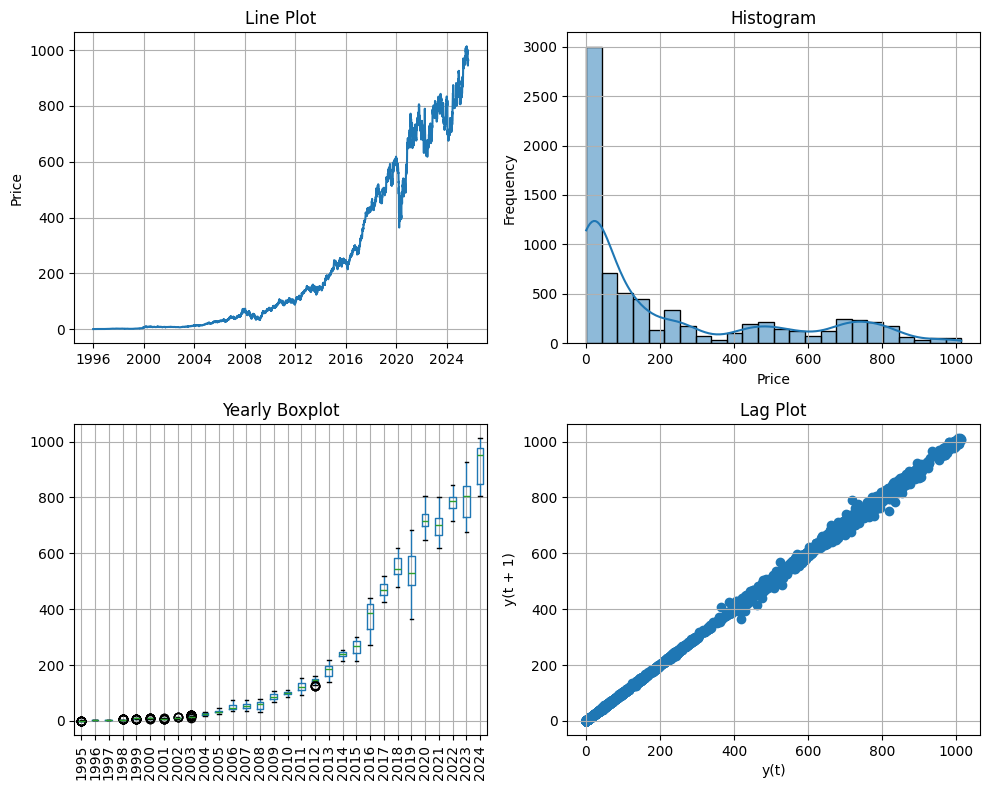

In [6]:
plt.figure(figsize=(10,8))

plt.subplot(2,2,1)
plt.plot(series)
plt.title("Line Plot")
plt.ylabel("Price")
plt.grid()

plt.subplot(2,2,2)
sns.histplot(series, kde=True)
plt.title("Histogram")
plt.ylabel("Frequency")
plt.grid()

plt.subplot(2,2,3)
yearly = pd.concat([pd.DataFrame(x[1].values) for x in series.groupby(series.index.year)], axis = 1)
yearly.columns = range(1995, 2025)
yearly.boxplot()
plt.xticks(rotation=90)
plt.title("Yearly Boxplot")

plt.subplot(2,2,4)
lag_plot(series)
plt.title("Lag Plot")
plt.grid()

plt.tight_layout()
plt.show()

these charts collectively show a series with an upward trend, some significant volatility, particularly after 2008, and a distribution with a positive skew. The strong autocorrelation suggests that this series may be suitable for predictive modeling using time series methods.

# Decomposition

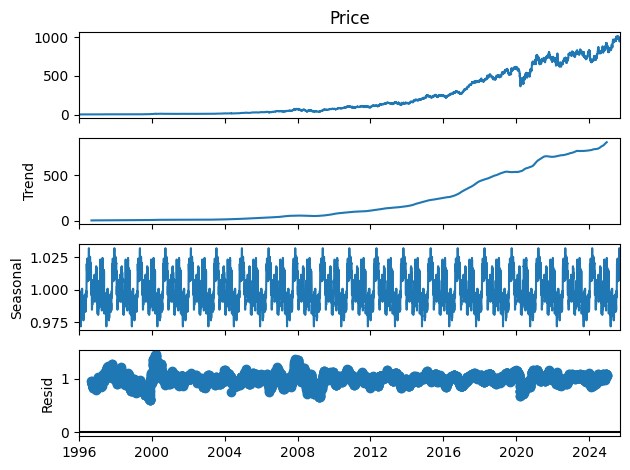

In [7]:
decomposition = seasonal_decompose(series, model='multiplicative', period=365)
decomposition.plot()
plt.show()

# Stationarity Check

## Summary Statistics

In [8]:
x = series.values
size = int(len(x)/2)
x1, x2 = x[:size], x[size:]
mean1, mean2 = x1.mean(), x2.mean()
var1, var2 = x1.var(), x2.var()
print("Mean for the first half of data: ", mean1, "Mean for the second half of data: ", mean2)
print("Variance for the first half of data: ", var1, "Variance for the second half of data: ", var2)

Mean for the first half of data:  21.682131870349973 Mean for the second half of data:  441.2111396185992
Variance for the first half of data:  515.9581607090226 Variance for the second half of data:  72199.16870121461


The first half of the data has a lower mean (730.76) and variance (288,455.73) compared to the second half, which has a higher mean (1,283.90) and variance (366,575.47), indicating an increase in both average values and variability over time.

## Augmented Dickey Fuller Test

In [9]:
result = adfuller(series.values)

print("ADF Statistics: ",result[0])
print("P-value: ",result[1])
print("Critical Values")
print(result[4])

if result[1] < 0.05:
    print("We reject the null hypothesis: the series does not have a unit root, i.e., it is stationary.")
else:
    print("We fail to reject the null hypothesis: the series has a unit root, i.e., it is non-stationary.")

ADF Statistics:  1.530154296813398
P-value:  0.9976321408839488
Critical Values
{'1%': np.float64(-3.431231493518619), '5%': np.float64(-2.8619295527920916), '10%': np.float64(-2.5669773546045564)}
We fail to reject the null hypothesis: the series has a unit root, i.e., it is non-stationary.


## Differencing

In [10]:
series_diff = series.diff(1)

result = adfuller(series_diff[1:].values)

print("ADF Statistics: ",result[0])
print("P-value: ",result[1])
print("Critical Values")
print(result[4])

if result[1] < 0.05:
    print("We reject the null hypothesis: the series does not have a unit root, i.e., it is stationary.")
else:
    print("We fail to reject the null hypothesis: the series has a unit root, i.e., it is non-stationary.")

ADF Statistics:  -15.07188953442808
P-value:  8.700820842981524e-28
Critical Values
{'1%': np.float64(-3.4312317312322715), '5%': np.float64(-2.8619296578277815), '10%': np.float64(-2.5669774105165732)}
We reject the null hypothesis: the series does not have a unit root, i.e., it is stationary.


After differencing the series does not have any unit roots i.e. time dependent components thus making it stationary

# Train Test Split

In [11]:
split = int(len(series)*0.8)
train, test = series[:split], series[split:]

print("Actual Data Size: ",len(series))
print("Train Data Size: ",len(train))
print("Test Data Size: ",len(test))

Actual Data Size:  7457
Train Data Size:  5965
Test Data Size:  1492


# ARIMA

## Plotting ACF and PACF

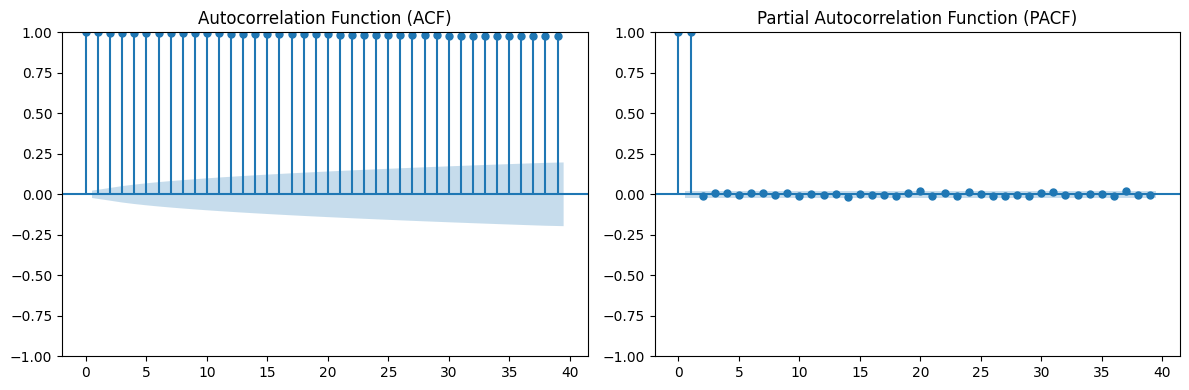

In [12]:
plt.figure(figsize=(12, 4))

# Plot ACF
plt.subplot(1, 2, 1)
plot_acf(series, ax=plt.gca())
plt.title("Autocorrelation Function (ACF)")

# Plot PACF
plt.subplot(1, 2, 2)
plot_pacf(series, ax=plt.gca())
plt.title("Partial Autocorrelation Function (PACF)")

plt.tight_layout()
plt.show()

## ARIMA

c:\Users\pavan\Desktop\PSY\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pavan\Desktop\PSY\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pavan\Desktop\PSY\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: A date index has been provided, but it has no associated frequency information and so will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
c:\Users\pavan\Desktop\PSY\venv\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:837: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  retur

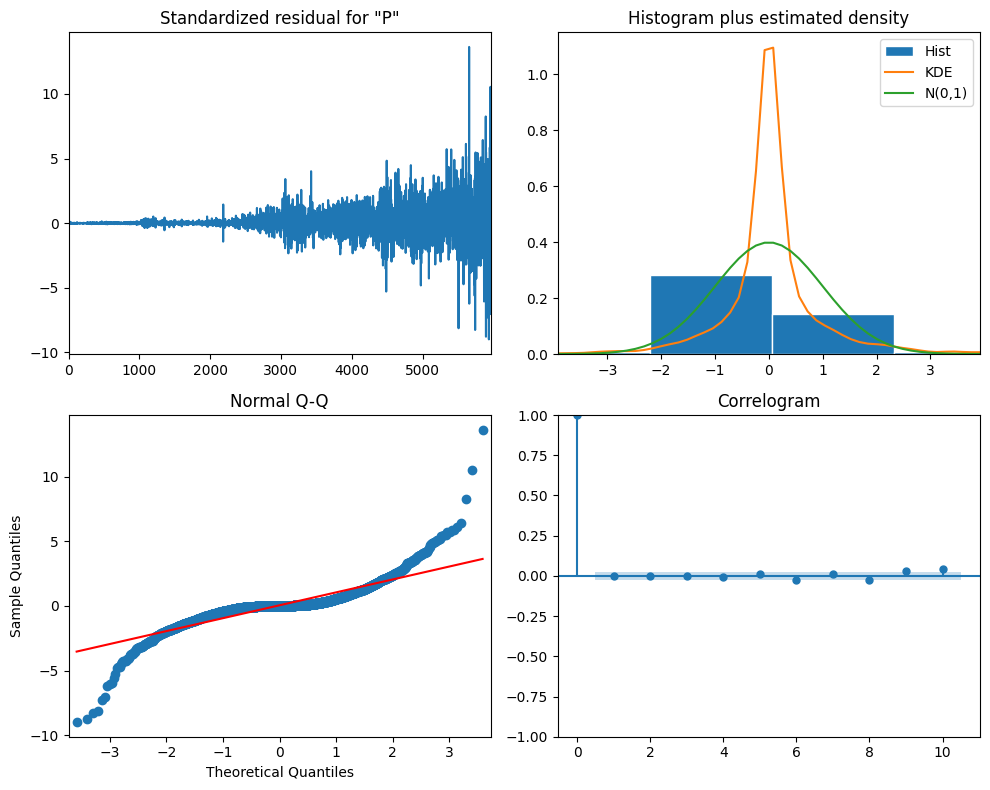

RMSE: 233.044


In [13]:
model = ARIMA(train, order=(5, 1, 1))
model_fit = model.fit()
y_pred = model_fit.forecast(steps=len(test))
resid = model_fit.resid
rmse = np.sqrt(mean_squared_error(test, y_pred))   
model_fit.plot_diagnostics(figsize=(10, 8))
plt.tight_layout()
plt.show()
print(f'RMSE: {rmse:.3f}')

# Residual Analysis

In [14]:
residuals = model_fit.resid

## Outlier Detection and Removal using IQR method

In [15]:
Q1 = residuals.quantile(0.25)
Q3 = residuals.quantile(0.75)
IQR = Q3 - Q1
lower_bound = Q1 - 1.5 * IQR
upper_bound = Q3 + 1.5 * IQR

outliers = residuals[(residuals < lower_bound) | (residuals > upper_bound)]
residuals_cleaned = residuals[(residuals >= lower_bound) & (residuals <= upper_bound)]

## Plotting the cleaned residauls

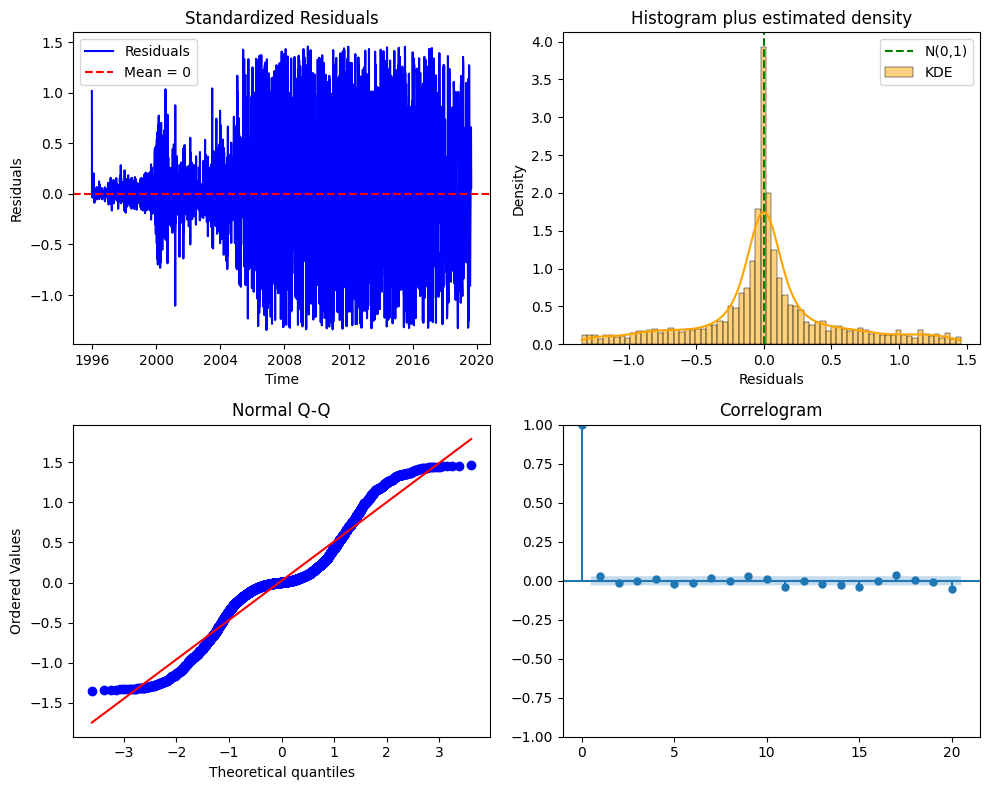

In [16]:
plt.figure(figsize=(10, 8))

plt.subplot(2, 2, 1)
plt.plot(residuals_cleaned, color='blue', label='Residuals')
plt.axhline(0, color='red', linestyle='--', label='Mean = 0')
plt.title('Standardized Residuals')
plt.xlabel('Time')
plt.ylabel('Residuals')
plt.legend()

plt.subplot(2, 2, 2)
sns.histplot(residuals_cleaned, kde=True, stat="density", color='orange', label='KDE')
plt.axvline(0, color='green', linestyle='--', label='N(0,1)')
plt.title('Histogram plus estimated density')
plt.xlabel('Residuals')
plt.legend()

plt.subplot(2, 2, 3)
stats.probplot(residuals_cleaned, dist="norm", plot=plt)
plt.title('Normal Q-Q')

plt.subplot(2, 2, 4)
plot_acf(residuals_cleaned, lags=20, ax=plt.gca())
plt.title('Correlogram')

plt.tight_layout()
plt.show()